[0.25, 0.5, 0.75, 1.0]
0.04537000410954225 0.0007223340001019096
0.3835708258109449 0.006265290000101231
0.6182799524449285 0.010608510000110982
0.8034693812117785 0.01485074800007169
0.9850023847421927 0.02224011800012704
0.9709624267526028 0.028844783000067764
0.7911015315415144 0.03547539700002744
0.5661804833985895 0.040421026000103666
0.29809067046736 0.04518251100012094
0.05066023733973593 0.04919337199999063
-0.23443310127140077 0.05376616900002773
-0.5026697592846985 0.05838244100004886
-0.7218849707790469 0.06283620199997131
-0.8748763003825516 0.06695287200000166
-0.9782998970296314 0.07167834500000936
-0.9948155225226267 0.07662134500014872
-0.9244188003280066 0.08122753399993599
-0.7705765588573201 0.08599841900013416
-0.5436115090482583 0.09085282499995628
-0.23910214663535082 0.0961573459999272
0.013890230883608126 0.1002210770000147
0.3019424268346469 0.10488175199998295
0.5393415655140813 0.10906634100001611
0.7478079167819344 0.11344467999992958
0.9226096889979852 0.11

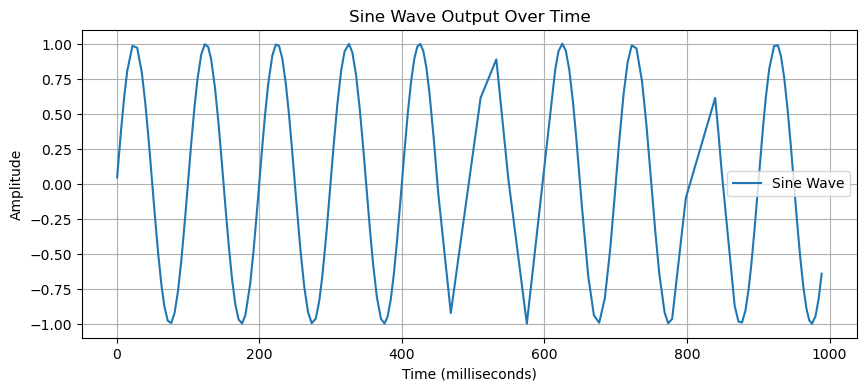

Finished generating the sine wave.


In [11]:
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt

class OscGenProcess:
    def __init__(self, amplitude, frequency, phase_shift, spk_threshold, duration=None):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase_shift = phase_shift
        self.duration = duration
        
        # Define thresholds where to send spikes
        num_steps = int(self.amplitude / (self.amplitude * spk_threshold))  # Number of thresholds
        self.thresholds = [self.amplitude * spk_threshold * i for i in range(1, num_steps + 1)]
        self.current_threshold_index = 0
        self.last_y = 0
        self.omega = 2 * np.pi * self.frequency

        # Initializing manager and shared lists correctly
        manager = multiprocessing.Manager()
        self.times = manager.list()
        self.outputs = manager.list()

        # Event for controlling the indefinite run
        self.stop_event = manager.Event()

    def generate_sine_wave(self):
        print(self.thresholds)
        period = 1 / self.frequency
        # interval = period / 100
        start_time = time.perf_counter()
        max_list_size = 50000  # Maximum number of elements in the list

        if self.duration is not None:
            end_time = start_time + self.duration

        while not self.stop_event.is_set() and (self.duration is None or time.time() < end_time):
            current_time = time.perf_counter() - start_time
            y = self.amplitude * np.sin(self.omega * current_time + self.phase_shift)
            print(y, current_time)
            # Ensure list does not exceed the maximum size
            if len(self.times) >= max_list_size:
                # Remove the oldest item
                self.times.pop(0)
                self.outputs.pop(0)

            # Append current time and output to the lists
            self.times.append(current_time * 1000)  # Convert time to milliseconds
            self.outputs.append(y)

            #check for spike send
            #self.check_and_send_spike(y)
        
            #time.sleep(interval)

    def run(self):
        self.process = multiprocessing.Process(target=self.generate_sine_wave)
        self.process.start()

    def stop(self):
        self.stop_event.set()
        self.process.join()

    '''
    def check_and_send_spike(self, y):
        increasing = y > self.last_y
        if increasing and y >= self.thresholds[self.current_threshold_index]:
            self.send_spike(y)
            if self.current_threshold_index < len(self.thresholds) - 1:
                self.current_threshold_index += 1
        elif not increasing and y <= self.thresholds[self.current_threshold_index]:
            self.send_spike(y)
            if self.current_threshold_index > 0:
                self.current_threshold_index -= 1
        self.last_y = y

    def send_spike(self, y): # Updated to include y in the output
        print(f"Spike sent at y={y}, current threshold{self.current_threshold_index}")
    '''
    def plot_results(self):
        plt.figure(figsize=(10, 4))
        plt.plot(list(self.times), list(self.outputs), label='Sine Wave')  # Convert Manager list to regular list
        plt.title('Sine Wave Output Over Time')
        plt.xlabel('Time (milliseconds)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()


if __name__ == '__main__':
    oscillator = OscGenProcess(amplitude=1, frequency=10, phase_shift=0, spk_threshold=0.25)
    oscillator.run()  # Start generating in a separate process
    time.sleep(1)  # Let it run for 2 seconds
    oscillator.stop()  # Stop the generation
    oscillator.plot_results()
    print("Finished generating the sine wave.")

Below are the script to parse the C++ code found in `SineWaveGenerator.cpp`

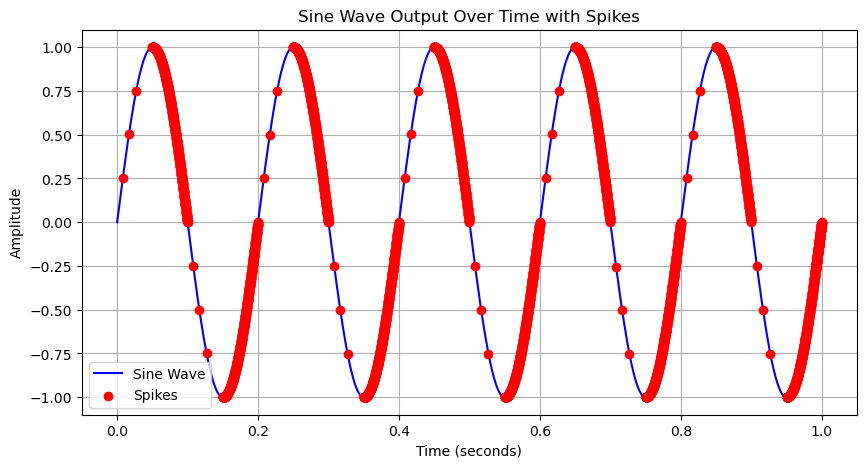

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV
data = pd.read_csv('sine_wave_data.csv')

# Plotting the sine wave
plt.figure(figsize=(10, 5))
plt.plot(data['Time'], data['Value'], label='Sine Wave', color='blue')

# Highlighting spikes
# Filter the rows where SpikeSent is 1 and plot those points
spike_data = data[data['SpikeSent'] == 1]
plt.scatter(spike_data['Time'], spike_data['Value'], color='red', label='Spikes', zorder=5)

# Adding labels and title
plt.title('Sine Wave Output Over Time with Spikes')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()